<a href="https://colab.research.google.com/github/Edenshmuel/ICU_Nutrition_ML/blob/main/Neural_Network_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import copy
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
!git clone https://github.com/Edenshmuel/ICU_Nutrition_ML.git

Cloning into 'ICU_Nutrition_ML'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 287.27 KiB | 3.83 MiB/s, done.


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Edenshmuel/ICU_Nutrition_ML/refs/heads/main/Food_and_Nutrition__.csv")
df.head()

,Ages,Gender,Height,Weight,Activity Level,Dietary Preference,Daily Calorie Target,Protein,Sugar,Sodium,Calories,Carbohydrates,Fiber,Fat,Breakfast Suggestion,Lunch Suggestion,Dinner Suggestion,Snack Suggestion,Disease
0,25,Male,180,80,Moderately Active,Omnivore,2000,120,125.0,24.0,2020,250,30.0,60,Oatmeal with berries and nuts,Grilled chicken salad with mixed greens,Salmon with roasted vegetables,Greek yogurt with fruit,Weight Gain
1,32,Female,165,65,Lightly Active,Vegetarian,1600,80,100.0,16.0,1480,200,24.0,40,Tofu scramble with veggies,Lentil soup with whole wheat bread,Vegetable stir-fry with brown rice,Apple with almond butter,"Weight Gain, Hypertension, Heart Disease"
2,48,Male,175,95,Sedentary,Vegan,2200,100,150.0,20.0,2185,300,36.0,65,Tofu and veggie breakfast burrito,Black bean burger on a whole wheat bun,Lentil and vegetable curry,Trail mix,Weight Gain
3,55,Female,160,70,Very Active,Omnivore,2500,140,175.0,28.0,2680,350,42.0,80,Greek yogurt with granola and fruit,Chicken and vegetable stir-fry,Turkey chili with brown rice,Banana with peanut butter,Weight Gain
4,62,Male,170,85,Sedentary,Vegetarian,2000,80,125.0,16.0,1815,250,30.0,55,Scrambled eggs with whole wheat toast and avocado,Quinoa salad with chickpeas and vegetables,Vegetarian chili with cornbread,Fruit and nut mix,Weight Gain


**Define Features and Target Variable**

In [4]:
X = df.drop(columns=["Daily Calorie Target"])
y = df["Daily Calorie Target"]

**Feature Selection**

Prevent Data Leakage: Remove Columns That Contain Target Information

In [6]:
X = df.drop(columns=["Calories"])

Removing Non-Contributing Columns

In [8]:
columns_to_remove = ["Dietary Preference", "Breakfast Suggestion", "Lunch Suggestion",
                     "Dinner Suggestion", "Snack Suggestion"]

X = df.drop(columns=columns_to_remove)

**Categorize Features: Numerical, Categorical, and Skewed Columns**

In [10]:
numerical_features = ["Ages", "Height", "Weight", "Protein", "Sugar", "Sodium", "Carbohydrates", "Fiber", "Fat"]
categorical_features = ["Gender", "Activity Level", "Disease"]

Features identified as right-skewed from EDA; applying log transformation

In [25]:
right_skewed_features = ["Protein", "Sugar", "Sodium", "Carbohydrates", "Fat"]

**Data Preprocessing: Pipelines for Scaling, Encoding, and Log Transformation**

Log Transform + Scaling for skewed features

In [17]:
log_scaler_pipeline = Pipeline(steps=[("log_transform", FunctionTransformer(np.log1p, validate=True)),
    ("scaler", StandardScaler())])

Standard Scaling for non-skewed features

In [18]:
scaler_pipeline = Pipeline(steps=[("scaler", StandardScaler())])

One-Hot Encoding for categorical features

In [19]:
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

Combine Transformations in ColumnTransformer

In [20]:
preprocessor = ColumnTransformer(transformers=[
    ("log_scaled", log_scaler_pipeline, right_skewed_features),  # Apply log transformation + scaling
    ("scaled", scaler_pipeline, list(set(numerical_features) - set(right_skewed_features))),  # Only scaling for non-skewed features
    ("cat", cat_transformer, categorical_features)  # Encode categorical features
])

Split data before applying transformations to prevent data leakage

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Apply the pipeline

In [22]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [26]:
print(f"✅ Training Data Processed: {X_train_transformed.shape} (Rows, Features)")
print(f"✅ Test Data Processed: {X_test_transformed.shape} (Rows, Features)")

✅ Training Data Processed: (1358, 29) (Rows, Features)
✅ Test Data Processed: (340, 29) (Rows, Features)


**Baseline Model**

In [34]:
y_test_copy = np.array(copy.copy(y_test))
np.random.shuffle(y_test_copy)
random_baseline_mae = mean_absolute_error(y_test, y_test_copy)

print(f"📊 Random Baseline MAE: {random_baseline_mae:.2f}")

📊 Random Baseline MAE: 633.68


**Neural Network Model**

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

Split the original training data into training and validation sets

In [41]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_transformed, y_train, test_size=0.2,
                                                              random_state=42)

Define and train the Neural Network

In [55]:
nn_model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_transformed.shape[1],)),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="linear")
])


nn_model.compile(optimizer=Adam(learning_rate=0.005), loss="mse", metrics=["mae"])


history = nn_model.fit(X_train_split, y_train_split,
                        epochs=100, batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=1)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 5516515.0000 - mae: 2279.0508 - val_loss: 5564091.0000 - val_mae: 2300.1270
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5495251.0000 - mae: 2275.4744 - val_loss: 5538048.5000 - val_mae: 2294.5354
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 5453893.0000 - mae: 2265.4827 - val_loss: 5461274.5000 - val_mae: 2278.0146
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5332716.5000 - mae: 2240.3767 - val_loss: 5259628.0000 - val_mae: 2234.2688
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 5099663.0000 - mae: 2188.7419 - val_loss: 4790804.5000 - val_mae: 2129.5857
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4605339.0000 - mae: 2075.5303 - val_loss: 3835215.7500 - val_mae: 1898.6434
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3536797.5000 - mae: 1806.6041 - val_loss: 2174289.0000 - val_mae: 1406.5045
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 184

Plot Training vs. Validation Loss

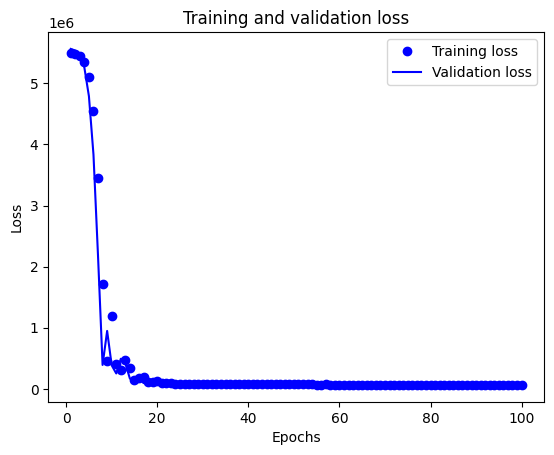

In [56]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()